In [41]:
import polars as pl
import json
import shap
import numpy as np
from great_tables import GT, md, html
from dotenv import load_dotenv
import os

from catboost import CatBoostRegressor,CatBoostClassifier, Pool

from sklearn.metrics import mean_poisson_deviance

import mlflow
from mlflow.models import infer_signature

from utils.utils import define_categorical_columns, define_continuous_columns
from utils.modelling_utils import assign_split, create_modelling_data

In [42]:

# Load variables from .env into os.environ
load_dotenv()

# Access them like normal environment variables
DATABRICKS_HOST = os.getenv("DATABRICKS_HOST")
DATABRICKS_TOKEN = os.getenv("DATABRICKS_TOKEN")
MODEL_VERSION_URI = os.getenv("MODEL_VERSION_URI")

os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN
os.environ["MLFLOW_ENABLE_UC_FUNCTIONS"] = "true"

In [3]:
mlflow.set_tracking_uri(uri="databricks")
mlflow.set_registry_uri("databricks-uc")

In [4]:
data_path = './processed-data/frequency_set.parquet'
frequency = pl.read_parquet(data_path)

In [5]:
with open('./config/frequency_config.json', 'r') as f:
    config = json.load(f)

In [6]:
features = config.get('features')

In [7]:
categorical_features = define_categorical_columns(frequency, features)
continuous_features = define_continuous_columns(features, categorical_features)

In [8]:
target = config.get('target')
exposure = config.get('exposure')
split = config.get('split')

In [9]:
frequency = assign_split(frequency, split)

In [10]:
train, X_train, y_train, log_exposure_train = create_modelling_data(frequency, features, 'Group', 'Train', target, exposure)
test, X_test, y_test, log_exposure_test = create_modelling_data(frequency, features, 'Group', 'Test', target, exposure)
holdout, X_holdout, y_holdout, log_exposure_holdout = create_modelling_data(frequency, features, 'Group', 'Holdout', target, exposure)

train_pool = Pool(X_train, label=y_train, cat_features=categorical_features, baseline = log_exposure_train)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_features, baseline = log_exposure_test)
holdout_pool = Pool(X_holdout, label=y_holdout, cat_features=categorical_features, baseline = log_exposure_holdout)

In [11]:

params = config.get('gbm_params').get('learning_params')
num_round = config.get('gbm_params').get('num_rounds')
early_stopping_rounds = config.get('gbm_params').get('early_stopping_rounds')

FrequencyModel = CatBoostRegressor(**params)
FrequencyModel.fit(train_pool, eval_set=[test_pool], early_stopping_rounds=early_stopping_rounds)

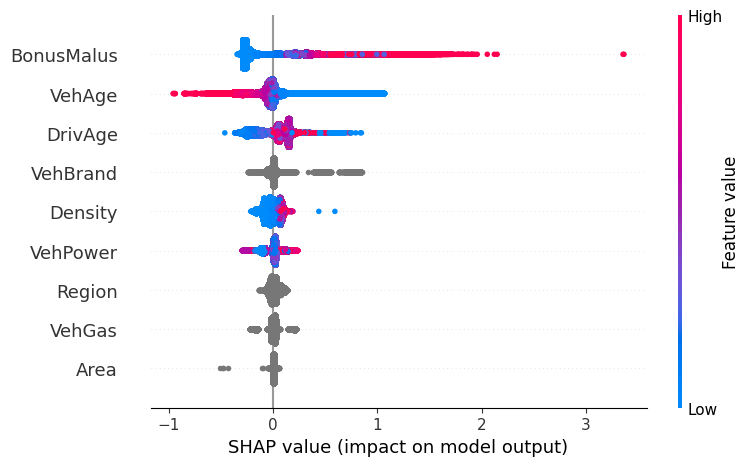

In [12]:
explainer = shap.TreeExplainer(FrequencyModel)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

In [13]:
predictions = FrequencyModel.predict(holdout_pool)
holdout = (
    holdout.with_columns(ClaimCountPrediction = pl.Series(predictions))
)

actuals = holdout.select('ClaimCount').to_numpy().ravel()
poisson_dev = mean_poisson_deviance(actuals, predictions)

In [26]:
import mlflow # Storing artifacts in a volume requires MLflow 2.15.0 or above

EXP_NAME = "/Shared/frequency_gbm"
CATALOG = "workspace"
SCHEMA = "default"
VOLUME = "models"
ARTIFACT_PATH = f"dbfs:/Volumes/{CATALOG}/{SCHEMA}/{VOLUME}" # can be a managed or external volume

mlflow.set_tracking_uri("databricks")
mlflow.set_registry_uri("databricks-uc")

if mlflow.get_experiment_by_name(EXP_NAME) is None:
    mlflow.create_experiment(name=EXP_NAME, artifact_location=ARTIFACT_PATH)
mlflow.set_experiment(EXP_NAME)

<Experiment: artifact_location='dbfs:/Volumes/workspace/default/models', creation_time=1757437681154, experiment_id='1022839245084458', last_update_time=1757437681154, lifecycle_stage='active', name='/Shared/frequency_gbm', tags={'mlflow.experiment.sourceName': '/Shared/frequency_gbm',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'ralph@pricing-frontier.co.uk',
 'mlflow.ownerId': '79094443683119'}>

In [27]:


# Start an MLflow run
with mlflow.start_run():
  # Log the hyperparameters
  mlflow.log_params(params)

  # Log the loss metric
  mlflow.log_metric("poisson_deviance", poisson_dev)

  # Set a tag that we can use to remind ourselves what this run was for
  mlflow.set_tag("Training Info", "Basic GBM for frequency")

  mlflow.set_tag("features_used", ",".join(features))
  mlflow.set_tag("data_used", data_path)


  # Infer the model signature
  signature = infer_signature(X_holdout, predictions)

  # Log the model
  model_info = mlflow.catboost.log_model(
      cb_model=FrequencyModel,
      name="frequency_gbm",
      signature=signature,
      input_example=X_holdout
  )

2025/09/09 18:08:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run unequaled-bee-394 at: https://dbc-2ec977bb-0eff.cloud.databricks.com/ml/experiments/1022839245084458/runs/a38c6d31ea3c49a5bd0543a369e28e64
🧪 View experiment at: https://dbc-2ec977bb-0eff.cloud.databricks.com/ml/experiments/1022839245084458


In [29]:
mlflow.register_model(model_info.model_uri, "workspace.default.frequency_gbm")

Successfully registered model 'workspace.default.frequency_gbm'.


Uploading artifacts:   0%|          | 0/8 [00:00<?, ?it/s]

Created version '1' of model 'workspace.default.frequency_gbm'.


<ModelVersion: aliases=[], creation_timestamp=1757438079772, current_stage=None, deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1757438107869, metrics=[<Metric: dataset_digest='', dataset_name='', key='poisson_deviance', model_id='m-57f807372484401b9318170ae66e81ac', run_id='a38c6d31ea3c49a5bd0543a369e28e64', step=0, timestamp=1757437701082, value=0.3018340304736188>], model_id='m-57f807372484401b9318170ae66e81ac', name='workspace.default.frequency_gbm', params=[<LoggedModelParameter: key='depth', value='3'>,
 <LoggedModelParameter: key='bagging_temperature', value='1'>,
 <LoggedModelParameter: key='random_strength', value='2'>,
 <LoggedModelParameter: key='l2_leaf_reg', value='2'>,
 <LoggedModelParameter: key='loss_function', value='Poisson'>,
 <LoggedModelParameter: key='learning_rate', va

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="databricks", registry_uri="databricks-uc")

versions = client.search_model_versions("name='workspace.default.frequency_gbm'")
latest_version = max(int(v.version) for v in versions)

client.set_registered_model_alias(name="workspace.default.frequency_gbm", alias="Champion", version=latest_version)



In [15]:
holdout.write_parquet('./processed-data/holdout_frequency_predictions.parquet')

In [40]:
import mlflow.pyfunc

uri = "models:/workspace.default.frequency_gbm@champion"
model = mlflow.pyfunc.load_model(uri)

preds = model.predict(X_holdout)


In [2]:
from mlflow.deployments import get_deploy_client

# Connect to the Databricks deployment target
client = get_deploy_client("databricks")

# Model URI using alias
model_uri = "models:/workspace.default.frequency_gbm@champion"

# Name of the deployment in Databricks
deployment_name = "frequency-gbm-champion"

# Deploy the model

# Try creating a new deployment
client.create_deployment(
    name=deployment_name,
    model_uri=model_uri,
    config={}
)


NotImplementedError: 

In [ ]:
from mlflow.deployments import get_deploy_client

client = get_deploy_client("databricks")

endpoint = client.create_endpoint(
    name="frequency-gbm-champion-endpoint",
    config={
        "served_entities": [
            {
                "name": "frequency-gbm-entity",
                "entity_name": "workspace.default.frequency_gbm",
                "entity_version": "1",  
                "workload_size": "Small",
                "scale_to_zero_enabled": True
            }
        ],
        "traffic_config": {
            "routes": [
                {
                    "served_model_name": "frequency-gbm-entity",
                    "traffic_percentage": 100
                }
            ]
        }
    }
)

print(f"Endpoint created: {endpoint}")


c:\Users\prici\python-for-pricing-course\.venv\Lib\site-packages\mlflow\deployments\databricks\__init__.py:465: UserWarning: Passing 'name', 'config', and 'route_optimized' as separate parameters is deprecated. Please pass the full API request payload as a single dictionary in the 'config' parameter.
  warnings.warn("\n".join(warnings_list), UserWarning)


Endpoint created: {'name': 'frequency-gbm-champion-endpoint', 'creator': 'ralph@pricing-frontier.co.uk', 'creation_timestamp': 1757444376000, 'last_updated_timestamp': 1757444376000, 'state': {'ready': 'NOT_READY', 'config_update': 'IN_PROGRESS', 'suspend': 'NOT_SUSPENDED'}, 'pending_config': {'served_entities': [{'name': 'frequency-gbm-entity', 'entity_name': 'workspace.default.frequency_gbm', 'entity_version': '1', 'workload_size': 'Small', 'workload_type': 'CPU', 'scale_to_zero_enabled': True, 'type': 'UC_MODEL', 'state': {'deployment': 'DEPLOYMENT_CREATING', 'deployment_state_message': 'Creating resources for served entity.'}, 'creator': 'ralph@pricing-frontier.co.uk', 'creation_timestamp': 1757444376000}], 'served_models': [{'name': 'frequency-gbm-entity', 'workload_size': 'Small', 'workload_type': 'CPU', 'scale_to_zero_enabled': True, 'model_name': 'workspace.default.frequency_gbm', 'model_version': '1', 'type': 'UC_MODEL', 'state': {'deployment': 'DEPLOYMENT_CREATING', 'deployme

In [ ]:

import mlflow.deployments

client = mlflow.deployments.get_deploy_client("databricks")

response = client.predict(
            endpoint="test-model-endpoint",
            inputs={"dataframe_split": {
                    "index": [0, 1],
                    "columns": ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"],
                    "data": [[5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2]]
                    }
                }
          )

In [48]:
# Example pandas DataFrame
df = X_holdout.head(1)

# Convert DataFrame to "dataframe_split" JSON
payload = {"dataframe_split": {
    "index": df.index.tolist(),
    "columns": df.columns.tolist(),
    "data": df.values.tolist()
}}

payload

{'dataframe_split': {'index': [0],
  'columns': ['VehPower',
   'VehAge',
   'DrivAge',
   'BonusMalus',
   'VehBrand',
   'VehGas',
   'Area',
   'Density',
   'Region'],
  'data': [[7.0,
    14.0,
    20.0,
    100.0,
    'B1',
    'Regular',
    'D',
    1329.0,
    'Ile-de-France']]}}

In [31]:
import pandas as pd
import mlflow.deployments

# Connect to Databricks deployment target
client = mlflow.deployments.get_deploy_client("databricks")

# Predict using the deployed endpoint
response = client.predict(
    endpoint="frequency-gbm-champion-endpoint",
    inputs=payload
)

print(response)


{'predictions': [0.3284297764608749]}


In [32]:
import requests

In [ ]:
# Make the POST request
response = requests.post(
    MODEL_VERSION_URI,
    headers={
        "Content-Type": "application/json"
    },
    auth=("token", DATABRICKS_TOKEN),
    data=json.dumps(payload))

response.json().get('predictions')

array([0.32842978])

In [80]:
import requests

# Example pandas DataFrame
df = X_holdout.head(1)

# Convert DataFrame to "dataframe_split" JSON
payload = {
    "dataframe_split": {
        "index": df.index.tolist(),
        "columns": df.columns.tolist(),
        "data": df.values.tolist()
    },
    "model_version_uri": MODEL_VERSION_URI,
    "databricks_token": DATABRICKS_TOKEN
}

url = "http://127.0.0.1:8000/predict"

response = requests.post(url, json=payload)

In [81]:
response.json()

{'premium': [197.05786587652494]}